# Gianlorenzo Urbano - 0001020458

#Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [163]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Lavoriamo da immagini ottenute a partire da MNIST.

In [164]:
from keras.preprocessing.image import ImageDataGenerator

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [165]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [166]:
my_gen = generator(x_train,5)

In [167]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


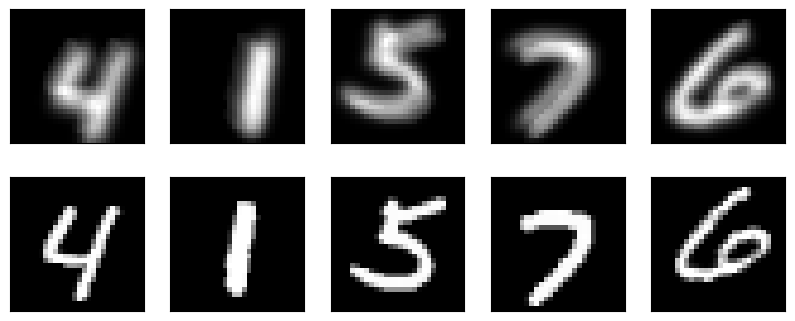

In [168]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


# Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

# Preparazione dati di training e validazione

Generiamo 200k immagini per il training (delle quali il 20% sarà usato per la validazione) e 10k per i test finali con il generatore fornito.

In [169]:
train_data_generator = generator(x_train,200000)

train_data_x, train_data_y = next(train_data_generator)

print(train_data_x.shape)

test_generator = generator(x_test,10000)

test_x,test_y = next(test_generator)

print(test_x.shape)

(200000, 28, 28)
(10000, 28, 28)


In [170]:
from keras.layers import Conv2D, BatchNormalization, Activation, Input, Conv2DTranspose, Multiply, ReLU, Concatenate, Dropout, Flatten, Dense, Reshape, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau

# Architettura del modello

L'architettura del modello scelto per risolvere il problema è quello di una rete encoder-decoder convoluzionale, simile alla UNet.

Per l'encoder, abbiamo una serie di convoluzioni e inception layer che portano l'immagine da una dimensione di 28x28x1 a 7x7x256.

Successivamente, come illustrato in [questo paper](https://ieeexplore.ieee.org/abstract/document/9099474), una sequenza di tre *ChannelWiseAttention* connessi densamente tra di loro aiuta a modellare relazioni più complesse tra i canali, oltre che a migliorare la rappresentazione latente del modello.

Il decoder invece mira a ricostruire l'immagine originale partendo dalla rappresentazione latente e incorporando features da skip connections realizzate attraverso *ScaleAttentionModules* (dal paper di prima).

## Layer convoluzionali e deconvoluzionali

Entrambe le funzioni incorporano la normalizzazione BatchNormalization per migliorare la stabilità del modello durante il training e utilizzano la funzione di attivazione ReLU per introdurre non linearità nei dati.

In [171]:
# Strati convoluzionali usati nell'encoder e nel decoder

def conv_layer(x, filters, kernel_size, strides=1, activation=True):
    x = Conv2D(filters, (kernel_size, kernel_size), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
      x = ReLU()(x)
    return x;


def deconv_layer(x, filters, kernel_size, strides=1):
    x = Conv2DTranspose(filters, (kernel_size, kernel_size), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x;

## Inception layers

Gli strati inception utilizzati nell'encoder, che prendono spunto da ResNet.

Entrambe le implementazioni seguono il concetto originale di Inception, cercando di catturare diverse scale e tipi di feature durante l'elaborazione. È però presente una connessione residuale al posto di quello che in una rete Inception sarebbe stato un MaxPooling.




In [180]:
def inception_layer(x, filters):
   # Branch 1: 1x1 Convolution
    branch_1x1 = conv_layer(x, filters / 2, 1, activation=False)

    # Branch 2: 3x3 Convolution
    branch_3x3 = conv_layer(x, filters, 1, activation=False)
    branch_3x3 = conv_layer(branch_3x3, filters, 3, activation=False)

    # Branch 3: 5x5 Convolution
    branch_5x5 = conv_layer(x, filters, 1, activation=False)
    branch_5x5 = conv_layer(branch_5x5, filters, 5, activation=False)

    # Concatenate all branches
    inception_block = Concatenate()([branch_1x1, branch_3x3, branch_5x5])

    inception_final = Conv2D(filters, 1, padding="same")(inception_block)

    output = Add()([inception_final, x])

    inception_block = ReLU()(output)

    return inception_block

def inception_layer_b(x, filters):
    # Branch 1: 1x1 Convolution
    branch_1x1 = conv_layer(x, filters / 2, 1, activation=False)

    # Branch 2: 3x3 Convolution
    branch_3x3 = conv_layer(x, filters, 1, activation=False)
    branch_3x3 = Conv2D(filters, (3, 1), padding="same")(branch_3x3)
    branch_3x3 = Conv2D(filters, (1, 3), padding="same")(branch_3x3)

    # Branch 3: 5x5 Convolution
    branch_5x5 = conv_layer(x, filters, 1, activation=False)
    branch_5x5 = Conv2D(filters, (5, 1), padding="same")(branch_5x5)
    branch_5x5 = Conv2D(filters, (1, 5), padding="same")(branch_5x5)

    # Concatenate all branches
    inception_block = Concatenate()([branch_1x1, branch_3x3, branch_5x5])

    inception_final = Conv2D(filters, 1, padding="same")(inception_block)

    output = Add()([inception_final, x])

    inception_block = ReLU()(output)

    return inception_block


## Layer di attenzione

Come illustrato in [questo paper](https://ieeexplore.ieee.org/abstract/document/9099474), sono qui utilizzati layer che sfruttano il meccanismo dell'attenzione per migliorare la rappresentazione latente del modello e per permettere una ricostruzione dell'immagine deblurrata più fedele.

- **ChannelWiseAttention**: focalizzandosi selettivamente su specifici canali, il modello può imparare a prestare attenzione a informazioni più rilevanti, migliorando potenzialmente la sua capacità di estrarre caratteristiche significative dai dati di input.

- **ScaleAttentionModule**: questo modulo consente al modello di regolare in modo adattivo l'importanza delle informazioni da diverse scale, contribuendo a una migliore rappresentazione delle caratteristiche e potenzialmente migliorando le prestazioni del modello nella cattura e ricostruzione delle caratteristiche durante il processo di decodifica.

In [173]:
class ChannelWiseAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(ChannelWiseAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        units = max(channels // self.reduction_ratio, 1)  # Ensure at least 1 unit

        self.conv1x1_1 = Conv2D(units, (1, 1), padding='same', activation='relu')
        self.conv1x1_2 = Conv2D(channels, (1, 1), padding='same', activation='sigmoid')

        super(ChannelWiseAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        avg_pool = GlobalAveragePooling2D()(inputs)

        # Apply the first convolution
        attention_weights = self.conv1x1_1(tf.expand_dims(tf.expand_dims(avg_pool, axis=1), axis=1))

        # Apply the second convolution
        attention_weights = self.conv1x1_2(attention_weights)

        # Upsample to match input shape
        attention_weights = tf.keras.layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation="nearest")(attention_weights)

        output = Multiply()([inputs, attention_weights])

        return output

class ScaleAttentionModule(tf.keras.layers.Layer):
  def __init__(self, filters, **kwargs):
        super(ScaleAttentionModule, self).__init__(**kwargs)
        self.filters = filters

        self.conv1 =  Conv2D(self.filters, (1, 1), padding="same", activation="sigmoid")
        self.conv2 = Conv2D(self.filters, (3, 3), padding="same")
        self.conv3 = Conv2D(self.filters, (3, 3), padding="same")

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

  def call(self, inputs, **kwargs):

        encoding, decoding = inputs

        add_0 = Add()([encoding, decoding])
        relu_1 = ReLU()(add_0)
        conv_1 = self.conv1(relu_1)

        multiply_1 = Multiply()([conv_1, decoding]);

        fconv = self.conv2(multiply_1)
        fconv = self.bn1(fconv)
        fconv = ReLU()(fconv)

        fconv = self.conv3(fconv)
        fconv = self.bn2(fconv)
        output = ReLU()(fconv)

        return output

Di seguito l'architettura finale del modello, che viene compilato con ottimizzatore *Adam* con learning rate iniziale di *0.0015*.

In [174]:
encoder_input = Input(shape=(28,28,1))

#HIDDEN LAYERS

# encoder

encoder_conv2 = conv_layer(encoder_input, 32, 3)
encoder_conv3 = conv_layer(encoder_conv2, 32, 3)
inception1 =  inception_layer(encoder_conv3, 32)
inception1 =  inception_layer(inception1, 32)
encoder_conv4 = conv_layer(inception1, 64, 3, strides=2)
inception2 =  inception_layer(encoder_conv4, 64)
encoder_conv5 = conv_layer(inception2, 128, 3, strides = 2)
inception3 = inception_layer_b(encoder_conv5, 128)
encoder_output = conv_layer(inception3, 256, 3)

latent1 = ChannelWiseAttention()(encoder_output)
latent2 = ChannelWiseAttention()(latent1)
concat1 = Concatenate()([ latent2, latent1])
latent3 = ChannelWiseAttention()(concat1)
latent_output = Concatenate()([latent3, latent2, latent1])

# decoder

decoder_deconv0 = deconv_layer(latent_output, 256, 3)
decoder_deconv1 = deconv_layer(decoder_deconv0, 128, 3)
upsampl1 = UpSampling2D((2, 2))(decoder_deconv1)
decoder_deconv1 = deconv_layer(upsampl1, 64, 3)
decoder_deconv2 = deconv_layer(decoder_deconv1, 64, 3)
skip3 = ScaleAttentionModule(filters=64)([encoder_conv4, decoder_deconv2])  # skip connection
concat1 = Concatenate()([decoder_deconv2, skip3])
decoder_deconv3 = deconv_layer(concat1, 64, 3)
upsampl2 = UpSampling2D((2, 2))(decoder_deconv3)
decoder_deconv4 = deconv_layer(upsampl2, 32, 3)
skip4 = ScaleAttentionModule(filters=32)([encoder_conv3, decoder_deconv4])  # skip connection
concat2 = Concatenate()([decoder_deconv4, skip4])
decoder_deconv4 = deconv_layer(concat2, 32, 3)
decoder_deconv5 = deconv_layer(decoder_deconv4, 32, 3)

decoder_output = Conv2DTranspose(1, (3,3), activation='relu', padding='same')(decoder_deconv5)

deblur_CNN = Model(inputs= encoder_input, outputs=decoder_output)

adam = Adam(0.0015)

deblur_CNN.compile(optimizer=adam, loss='mse')

deblur_CNN.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_73 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_1972 (Conv2D)        (None, 28, 28, 32)           320       ['input_73[0][0]']            
                                                                                                  
 batch_normalization_1841 (  (None, 28, 28, 32)           128       ['conv2d_1972[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 re_lu_1322 (ReLU)           (None, 28, 28, 32)           0         ['batch_normalization_1

Procediamo ad allenare il modello con le 200k immagini di training generate in precedenza, per 15 epoche con batch size 64. Utilizziamo un reducer per il learning rate ed early stopping.

In [175]:
lr_reducer = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=np.sqrt(0.1), min_lr=0.5e-6, verbose=1, cooldown=0)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
callbacks = [lr_reducer, early_stopping]

EPOCHS = 15


history = deblur_CNN.fit(train_data_x, train_data_y, epochs= EPOCHS, batch_size= 64, callbacks=callbacks, validation_split=0.2)

Epoch 1/15
2500/2500 [==============================] - 184s 65ms/step - loss: 0.0086 - val_loss: 0.0044 - lr: 0.0015
Epoch 2/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0036 - val_loss: 0.0033 - lr: 0.0015
Epoch 3/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0029 - val_loss: 0.0034 - lr: 0.0015
Epoch 4/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0025 - val_loss: 0.0023 - lr: 0.0015
Epoch 5/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0022 - val_loss: 0.0027 - lr: 0.0015
Epoch 6/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0020 - val_loss: 0.0020 - lr: 0.0015
Epoch 7/15
2500/2500 [==============================] - 163s 65ms/step - loss: 0.0019 - val_loss: 0.0020 - lr: 0.0015
Epoch 8/15
2500/2500 [==============================] - ETA: 0s - loss: 0.0018
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0004743416531483977.
2500/2500 [========

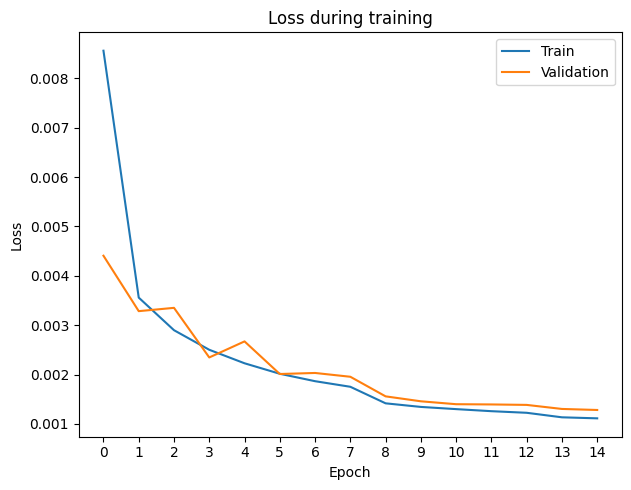

In [176]:
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss during training")
plt.xticks(np.arange(0, EPOCHS , 1))
plt.tight_layout()
plt.show()


Di seguito vengono mostrati alcuni risultati del modello. Attraverso la funzione <code>plot_n_samples</code> vengono generate alcune immagini, che possono anche essere ruotate di multipli di 90 gradi.

1/1 [==============================] - 1s 888ms/step


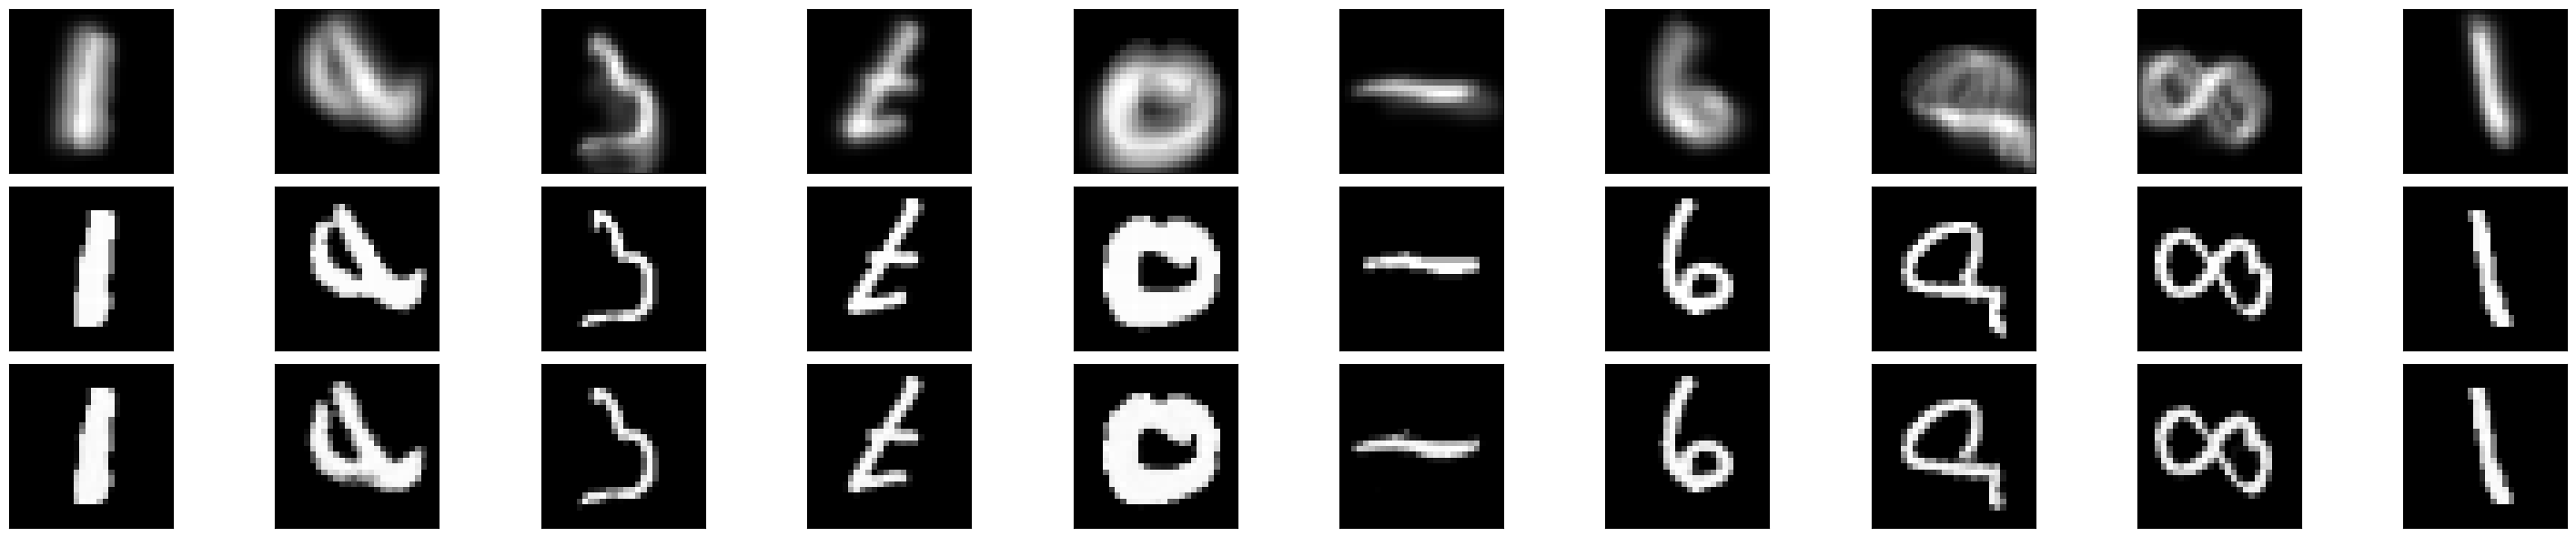

1/1 [==============================] - 0s 25ms/step


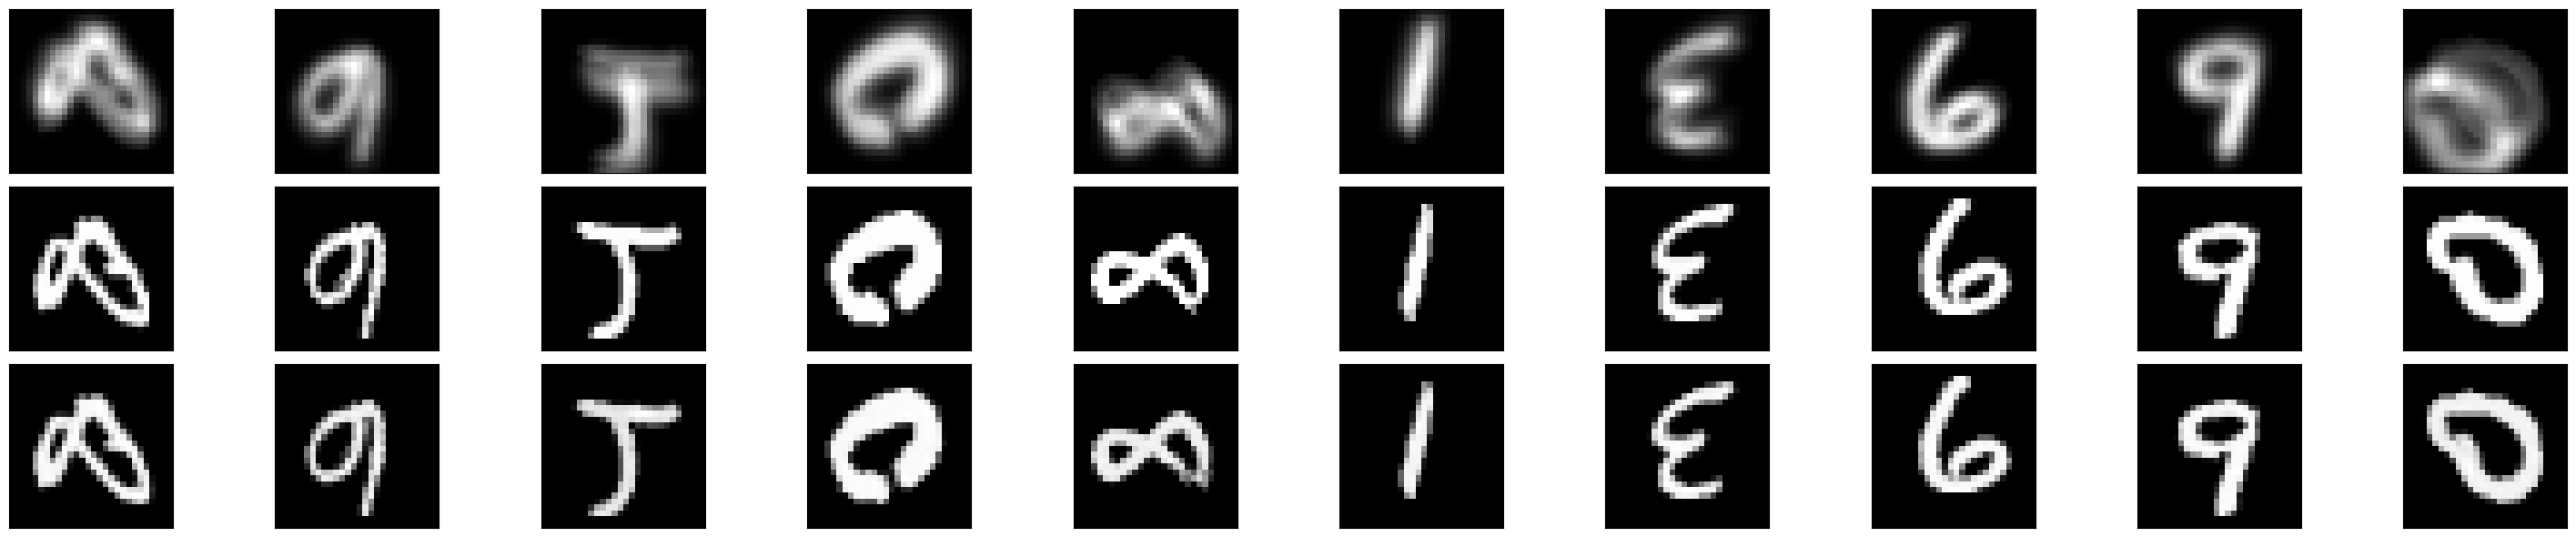

1/1 [==============================] - 0s 24ms/step


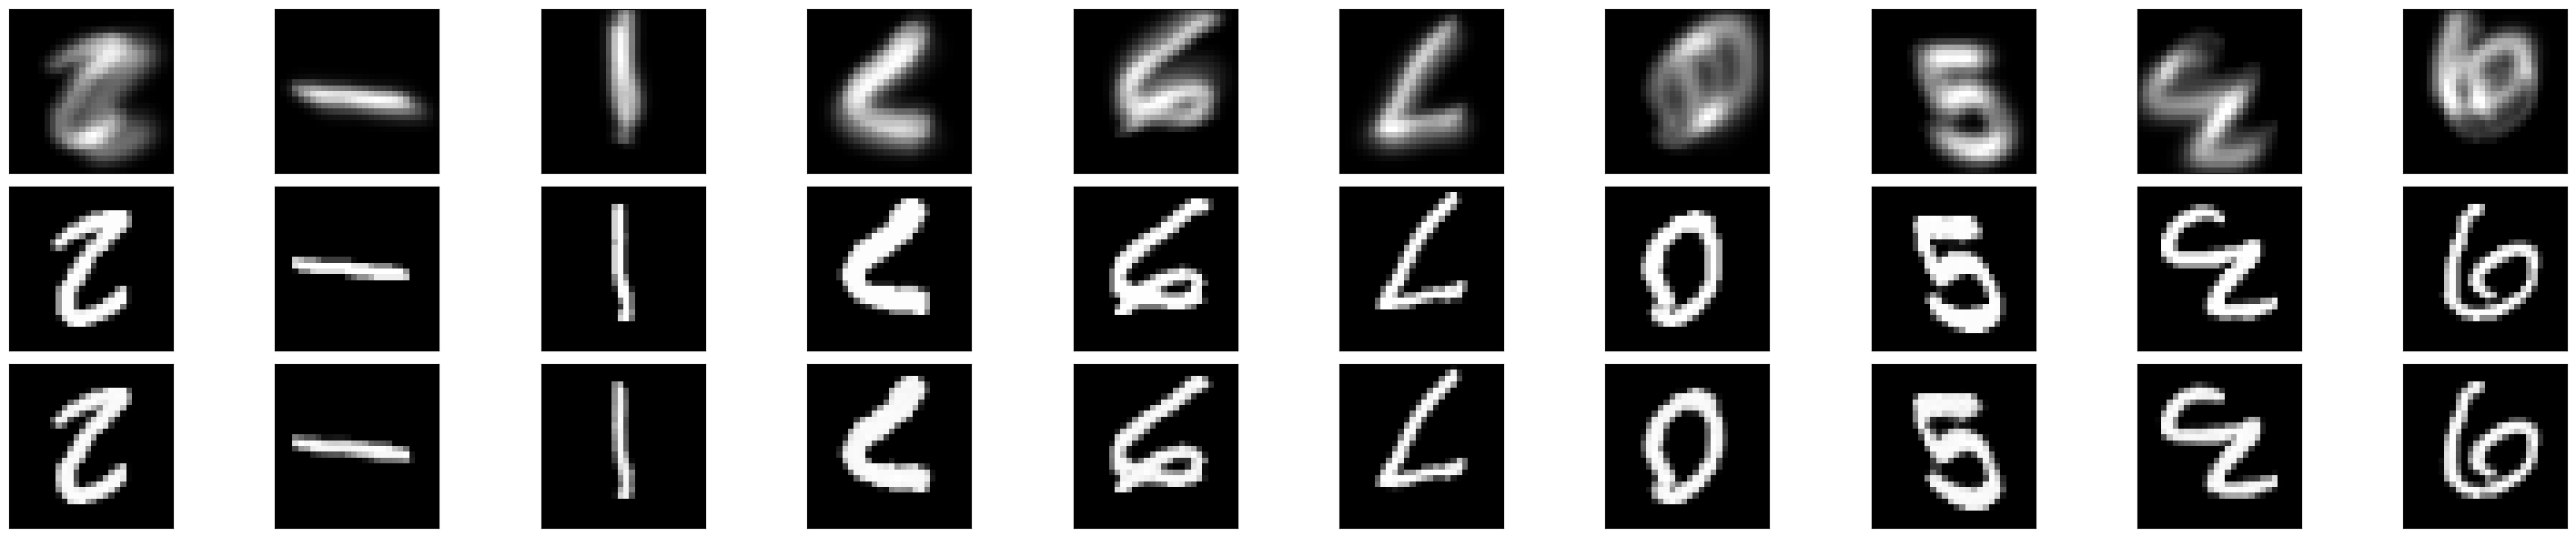

In [177]:
def plot_results(blurred, real, predicted):
    no = blurred.shape[0]
    plt.figure(figsize=(3*no, 6))
    for i in range(no):
        # display blurred
        ax = plt.subplot(3, no, i + 1)
        plt.imshow(blurred[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display real
        ax = plt.subplot(3, no, i + 1 + no)
        plt.imshow(real[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display prediction
        ax = plt.subplot(3, no, i + 1 + 2*no)
        plt.imshow(predicted[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

def random_rotate_90_degrees(x, y):
    array = np.array(x)
    truth = np.array(y)

    num_matrices, rows, cols = array.shape

    # Generate random rotation angles for each matrix
    rotation_angles = np.random.choice([0, 0, 90, 180, 270], size=num_matrices)

    rotated_array = np.empty_like(array)

    # Rotate each matrix in the input array
    for i in range(num_matrices):
        rotated_array[i] = np.rot90(array[i], k=int(rotation_angles[i] / 90), axes=(0, 1))
        truth[i] = np.rot90(truth[i], k=int(rotation_angles[i] / 90), axes=(0, 1))

    return rotated_array, truth


def plot_n_samples(n, k=1, rotation_angles=[0, 90, 180, 270]):
  for i in range(1, k+1):
      test_generator = generator(x_test,n)
      test_x,test_y = next(test_generator)

      rotated_x_test, rotated_y_test = random_rotate_90_degrees(test_x, test_y)

      rotated_x_test = np.expand_dims(rotated_x_test, axis=-1)
      rotated_y_test = np.expand_dims(rotated_y_test, axis=-1)

      test_y_pred = deblur_CNN.predict(rotated_x_test)

      # Plot results
      plot_results(rotated_x_test, rotated_y_test, test_y_pred)

plot_n_samples(10, 3)



Procediamo quindi con il test finale. Come da consegna, viene eseguito un test su 10k immagini per 10 volte, riportando oltre al richiesto *mse medio* anche altre metriche utili come SSIM e PSNR.

In [178]:
from skimage import metrics

mse_results = []
psnr = 0;
ssim_index = 0;

for i in range(0, 10):
    test_generator = generator(x_test,10000)
    test_x,test_y = next(test_generator)

    test_x = np.expand_dims(test_x,axis=-1)
    test_y = np.expand_dims(test_y,axis=-1)

    test_y_pred = deblur_CNN.predict(test_x)
    mse = np.mean(np.square(test_y_pred - test_y))
    mse_results.append(mse)

    psnr += metrics.peak_signal_noise_ratio(test_y.squeeze(), test_y_pred.squeeze())

    ssim_index += metrics.structural_similarity(test_y.squeeze(), test_y_pred.squeeze())


# Calcola la media dei risultati
average_mse = np.mean(mse_results)

# Calcola la deviazione standard dei risultati
std_deviation_mse = np.std(mse_results)


print("----METRICHE AGGIUNTIVE----")
print("PSNR:", psnr / 10)
print("SSIM Index:", ssim_index / 10)

print("----METRICHE RICHIESTE----")
print("Media MSE:", average_mse)
print("Deviazione standard MSE:", std_deviation_mse)

313/313 [==============================] - 3s 10ms/step
----METRICHE AGGIUNTIVE----
PSNR: 28.943835339725922
SSIM Index: 0.9913872552973186
----METRICHE RICHIESTE----
Media MSE: 0.0012753776
Deviazione standard MSE: 1.2922652e-05


# MSE MEDIO 0.001275
# DEVIAZIONE STANDARD MSE: 1.2922652e-05




In [179]:
deblur_CNN.save("best_so_far.keras")